In [60]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import torch
import copy
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b7, resnet50
from torch.utils.data import DataLoader
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

# Get the dataset and label matrices

In [61]:
TRAIN_ANNOTATIONS_PATH = "../fdata/train/annotations.json"
TRAIN_IMAGE_DIRECTIORY = "../fdata/train/images/"
train_coco = COCO(TRAIN_ANNOTATIONS_PATH)
with open(TRAIN_ANNOTATIONS_PATH) as f:
  train_annotations_data = json.load(f)
category_ids = train_coco.loadCats(train_coco.getCatIds())
category_names = [_["name_readable"] for _ in category_ids]

VAL_ANNOTATIONS_PATH = "../fdata/val/annotations.json"
VAL_IMAGE_DIRECTIORY = "../fdata/val/images/"
val_coco = COCO(VAL_ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=7.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [62]:
# category_names

In [63]:
meta = {
    'path_to_dataset': '../fdata',
    'path_to_images': '../fdata'
}

In [64]:
base_path = meta['path_to_dataset']
data = {}
for phase in ['train', 'val']:
    data[phase] = {}
    data[phase]['labels'] = np.load(os.path.join(base_path, 'formatted_{}_labels.npy'.format(phase)))
    data[phase]['labels_obs'] = np.load(os.path.join(base_path, 'formatted_{}_labels_obs.npy'.format(phase)))
    data[phase]['images'] = np.load(os.path.join(base_path, 'formatted_{}_images.npy'.format(phase)))

In [65]:
len(data['val']['images'])

946

# Explore models

In [66]:
effnet7 = efficientnet_b7()
torch.nn.Sequential(*list(effnet7.children())[-1])

Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=2560, out_features=1000, bias=True)
)

In [67]:
effnet7.classifier[1] = torch.nn.Linear(1, 2, bias=True)
effnet7.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=1, out_features=2, bias=True)
)

In [68]:
res = resnet50()
torch.nn.Sequential(*list(res.children()))[-1]

Linear(in_features=2048, out_features=1000, bias=True)

# Inference

In [69]:
def get_cat_name_from_img_id(img_id, phase='val'):
    coco = train_coco if phase == 'train' else val_coco        
    anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
    cat_ids = [_['category_id'] for _ in anns]
    cats = coco.loadCats(ids=cat_ids)
    cat_names = [_['name_readable'] for _ in cats]
    return sorted(list(set(cat_names)))

print(get_cat_name_from_img_id(131072,'train'))
print(get_cat_name_from_img_id(8082))

['bread_wholemeal', 'jam']
['fondue']


In [70]:
def get_cat_name_from_img_path(img_path, phase):
    images = np.load(os.path.join(base_path, 'formatted_{}_images.npy'.format(phase)))
    labels = np.load(os.path.join(base_path, 'formatted_{}_labels.npy'.format(phase)))

    id_row = np.where(images == img_path)[0][0] # get the i_th row containing img name
    return [category_names[i] for i in np.where(labels[id_row] == 1)[0]]

get_cat_name_from_img_path('train/images/131072.jpg', 'train')

['bread_wholemeal', 'jam']

In [71]:
import models

# fdata_mean = [0.5957, 0.5094, 0.4278]
# fdata_std = [0.2123, 0.2210, 0.2308]

imagenet_mean = [0.5957, 0.5094, 0.4278]
imagenet_std = [0.2104, 0.2192, 0.2290]

phase = 'val'
images = np.load(os.path.join(base_path, 'formatted_{}_images.npy'.format(phase)))
labels = np.load(os.path.join(base_path, 'formatted_{}_labels.npy'.format(phase)))
labels_obs = np.load(os.path.join(base_path, 'formatted_{}_labels_obs.npy'.format(phase)))

def get_model(get_best = True):
  P = {}
  P['arch'] = 'resnet50'
  P['use_pretrained'] = True
  P['freeze_feature_extractor'] = True
  P['num_classes'] = 323
  P['feat_dim'] = 2048
  if get_best:
    best_state_path = './multi_label_experiment_2024_01_15_02-08-26_coco_fine_tuned_from_linear/best_model_state_f_0.pt'
    best_state = torch.load(best_state_path, map_location=torch.device('cpu'))
    model = models.ImageClassifier(P, None, None)
    model.load_state_dict(best_state)
    return model
  else:
    return models.ImageClassifier(P, None, None)

def get_data(image_path):
  tx = transforms.Compose([
      transforms.Resize((448, 448)),
      transforms.ToTensor(),
      transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
  ])
  with Image.open(image_path) as I_raw:
    I = torch.unsqueeze(tx(I_raw.convert('RGB')), axis=0)
  return I

def get_out(image_path):
  model_f = get_model(True)
  model_f.eval()
  with torch.set_grad_enabled(False):
    img = get_data(image_path)

    logits = model_f(img)
    preds = torch.sigmoid(logits)
    if preds.dim() == 1:
        preds = torch.unsqueeze(preds, 0)[0]
  return preds

def inference(image_path, threshold=0.5):
  preds = get_out(image_path)

  if threshold == 'max':
    threshold = max(preds).item()
    
  return [category_names[i] for i in np.where(preds >= threshold)[0]]

In [72]:
base_path = '../fdata'
img_name = 'train/images/131072.jpg'

out = inference(os.path.join(base_path, img_name), threshold=0.12)
out

c:\Users\dangc\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dangc\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['Beetroot, steamed, without addition of salt',
 'bread_wholemeal',
 'jam',
 'butter',
 'bread_whole_wheat',
 'mixed_salad_chopped_without_sauce']

# Get pics with cat name or id

In [73]:
def get_img_have_cat_name(cat_name, phase):
    coco = train_coco if phase == 'train' else val_coco
    cat_ids = coco.getCatIds(catNms=cat_name)
    anns = coco.getAnnIds(catIds=cat_ids)
    ann = coco.loadAnns(ids=anns)
    img_ids = set([_['image_id'] for _ in ann])
    len(img_ids) == len(ann) #True
    return img_ids

def get_img_have_all_cat_names(cat_names, phase):
    pics = [get_img_have_cat_name([cat_name], phase) for cat_name in cat_names]
    return set.intersection(*pics)

def count_pic_have_all_cat_names(cat_names, phase):  
    return len(set(get_img_have_all_cat_names(cat_names, phase)))

In [74]:
def show_img_with_ids(img_id, phase):
    path = f'../fdata/{phase}/images/{str(int(img_id)).zfill(6)}.jpg'
    get_image = Image.open(path)
    plt.imshow(get_image)
    plt.show()

def show_img_have_cat_names(cat_names, phase, num_of_pics=1):
    img_ids = get_img_have_all_cat_names(cat_names, phase)
    for img_id in list(img_ids)[:num_of_pics]:
        show_img_with_ids(img_id, phase)

# show_img_have_cat_names(['bread_white'], 'train')

# Frequent itemset mining algorithm (FP-Growth)

In [75]:
from collections import defaultdict
def readData(path):
    """
    Parameters
    --------------------------
        path: list of database D.
    --------------------------
    Returns
        data: a dictionary for representing database D
                 - keys: transaction tids
                 - values: itemsets.
        s: support of distict items in D.
    """
    data = {}
    s = defaultdict(lambda: 0) # Initialize a dictionary for storing support of items in I.  
    tid = 1
    for line in path:
        itemset = set(line) # a python set is a native way for storing an itemset.
        for item in itemset:  
            s[item] += 1     #Why don't we compute support of items while reading data?
        data[tid] = itemset
        tid += 1
    return data, s

In [76]:
def joinset(a, b):
    ret = set(list(a) + list(b))
    return ret

class TP:
    def __init__(self, data=None, s=None, minSup=None):
        self.data = data
        self.s = {}

        for key, support in sorted(s.items(), key=lambda item: item[1]):
            self.s[key] = support

        self.minSup = minSup
        self.L = {}  # Store frequent itemsets mined from database
        self.runAlgorithm()

    def initialize(self):
        tree = {}

        search_space = {}
        for item, support in self.s.items():
            search_space[item] = {}

            search_space[item]['itemset'] = [item]
            search_space[item]['pruned'] = False
            search_space[item]['support'] = support

            tree[item] = {}
        return tree, search_space

    def computeItemsetSupport(self, itemset):
        support = 0
        for transaction in list(self.data.values()):
            support += set(itemset).issubset(transaction)
        return support

    def get_sub_tree(self, k, tree, search_space, itter_node):
        if k == 0:
            return search_space[itter_node]['support']
        subtree = search_space[itter_node]
        for node in subtree.keys():
            k-=1
            self.get_sub_tree(k,tree,search_space,node)


    def prune(self, k, tree, search_space):
        if self.L.get(k) is None: self.L[k] = []
        for item in search_space:
            if search_space[item]['support'] < self.minSup:
                search_space[item]['pruned'] = True
            else:
                self.L[k].append(search_space[item]['itemset'])

    def generateSearchSpace(self, k, tree, search_space):
        items = list(tree.keys())
        l = len(items)
        self.prune(k, tree, search_space)
        if l == 0: return  # Stop condition
        for i in range(l - 1):
            sub_search_space = {}
            sub_tree = {}
            a = items[i]
            if search_space[a]['pruned']: continue

            for j in range(i + 1, l):
                b = items[j]
                search_space[a][b] = {}
                tree[a][b] = {}
                newset = joinset(search_space[a]['itemset'],search_space[b]['itemset'])                
                
                # Second add newset to search_space
                search_space[a][b]['itemset'] = newset
                search_space[a][b]['pruned'] = False
                search_space[a][b]['support'] = self.computeItemsetSupport(newset)
                
                sub_search_space[b] = search_space[a][b]

            sub_tree = tree[a]
            #  Generate search_space for k+1-itemset
            self.generateSearchSpace(k + 1, sub_tree, sub_search_space)

    def runAlgorithm(self):
        tree, search_space = self.initialize()  # generate search space for 1-itemset
        self.generateSearchSpace(1, tree, search_space)

    def miningResults(self):
        return self.L

# Basic Error Analysis

## 0.5 threshhold

In [77]:
#### Run this cell when run this notebook for the first time 
#    to create the pairs of true labels and guessed labels at 0.5 threshold ####

# def create_true_guess(phase, threshold, save_filename):
#     true_guess = []
#     base_path = '../fdata'
#     for img_path in np.load(os.path.join(base_path, 'formatted_{}_images.npy'.format(phase))):
#         tr = get_cat_name_from_img_path(img_path, phase)
#         gu = inference(os.path.join(base_path, img_path), threshold)
#         if tr != gu:
#             true_guess.append((tr,gu))
#     torch.save(true_guess, save_filename)

# create_true_guess('val', 0.5, 'guess_50_val.pt')

In [78]:
# the guessed label set can be empty.
guess_50_val = torch.load('guess_50_val.pt')
print(len(guess_50_val))
# guess_50_val

631


In [79]:
def clean_true_guess(true_guess): 
    true_guess_clean = []
    for _ in true_guess:
        if _[1] != []:
            true_guess_clean.append(_)
    return true_guess_clean

# discard pairs with empty predictions
guess_50_clean = clean_true_guess(guess_50_val)
len(guess_50_clean)
# guess_50_clean

178

In [80]:
def true_guess_have_over_1_guess(tr_gu):
    tr_gu_over_1_stuff = []
    for _ in tr_gu:
        if len(_[1]) != 1:
            tr_gu_over_1_stuff.append(_)
    return tr_gu_over_1_stuff

# get pairs with more than 1 predicted label
guess_50_over_1_stuff = true_guess_have_over_1_guess(guess_50_clean)
len(guess_50_over_1_stuff)
# guess_50_over_1_stuff

12

In [81]:
def split_1TP_wr(tr_gu):
    true_guess_1 = [] # guess 1 item correctly
    true_guess_wr = [] # guess totally wrong
    for _ in tr_gu:
        if set(_[1]).intersection(set(_[0])):
            true_guess_1.append(_)
        else:
            true_guess_wr.append(_)
    true_guess_1.sort()
    true_guess_wr.sort()
    return true_guess_1, true_guess_wr

# Separate pairs into pairs that guessed 1 label correctly and pairs that guessed completely wrong.
true_guess_1, true_guess_wr = split_1TP_wr(guess_50_clean)
print(len(true_guess_1),';',len(true_guess_wr))
# true_guess_1
# true_guess_wr

126 ; 52


### Count frequently misclassified labels in true labels and in predicted labels.

In [82]:
def count_class(sets, res):
    for __ in sets:
        if __ in res.keys():
            res[__] += 1
        else:
            res[__] = 1

def count_frequently_misclassified_labels(true_guess_wr):
    misclassified_labels_in_true_set = {}
    misclassified_labels_in_guess_set = {}
    for _ in true_guess_wr:
        count_class(_[0], misclassified_labels_in_true_set)
        count_class(_[1], misclassified_labels_in_guess_set)
    return dict(sorted(misclassified_labels_in_true_set.items(), key=lambda item: -item[1])), dict(sorted(misclassified_labels_in_guess_set.items(), key=lambda item: -item[1]))

In [89]:
misclassified_labels_in_true_set, misclassified_labels_in_guess_set = count_frequently_misclassified_labels(true_guess_wr)
# misclassified_labels_in_true_set
# misclassified_labels_in_guess_set

### Split the completely wrong true-guess-es into pairs of 1 true and 1 guess and to exploit pairs that are easy to misclassify. 

In [84]:
def to_pair_true_guess(true_guess):
    pairs = []
    for _ in true_guess:
        for __ in _[0]:
            for ___ in _[1]:
                if __ != ___: # remove correct guess pairs
                    pairs.append([__, ___])
    return pairs
wr_pairs = to_pair_true_guess(true_guess_wr)
# wr_pairs

In [85]:
data_x, s = readData(wr_pairs)
# print(s.items())
a = TP(data=data_x, s=s, minSup=2)
print(a.miningResults()[2])

[{'bread_whole_wheat', 'bread_wholemeal'}, {'water', 'water_with_lemon_juice'}, {'water', 'glucose_drink_50g'}, {'white_coffee', 'coffee'}, {'mixed_salad_chopped_without_sauce', 'salad_leaf_salad_green'}, {'water', 'soft_drink_with_a_taste'}, {'coffee', 'ristretto_with_caffeine'}, {'espresso', 'ristretto_with_caffeine'}, {'espresso', 'coffee'}]


In [90]:
def wr_pairs_count(wr_pairs):
    food_pairs = {}
    for _ in wr_pairs:
        _.sort()
        if tuple(_) not in food_pairs.keys():
            food_pairs[tuple(_)] = 1
        else:
            food_pairs[tuple(_)] += 1

    food_pairs = dict(sorted(food_pairs.items(), key=lambda item: -item[1]))
    return food_pairs

food_pairs = wr_pairs_count(wr_pairs)
# food_pairs

### Confusing matrix for pairs in completely wrong pairs (wr_pairs)

In [91]:
# remove pairs that appear too rarely
filtered_pairs = {key: value for key, value in food_pairs.items() if value > 1}
filtered_pairs

{('coffee', 'espresso'): 4,
 ('soft_drink_with_a_taste', 'water'): 4,
 ('glucose_drink_50g', 'water'): 3,
 ('espresso', 'ristretto_with_caffeine'): 3,
 ('bread_whole_wheat', 'bread_wholemeal'): 2,
 ('mixed_salad_chopped_without_sauce', 'salad_leaf_salad_green'): 2,
 ('coffee', 'ristretto_with_caffeine'): 2,
 ('water', 'water_with_lemon_juice'): 2,
 ('coffee', 'white_coffee'): 2}

C:\Users\dangc\AppData\Local\Temp\ipykernel_14172\587054758.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = matrix.fillna(0)


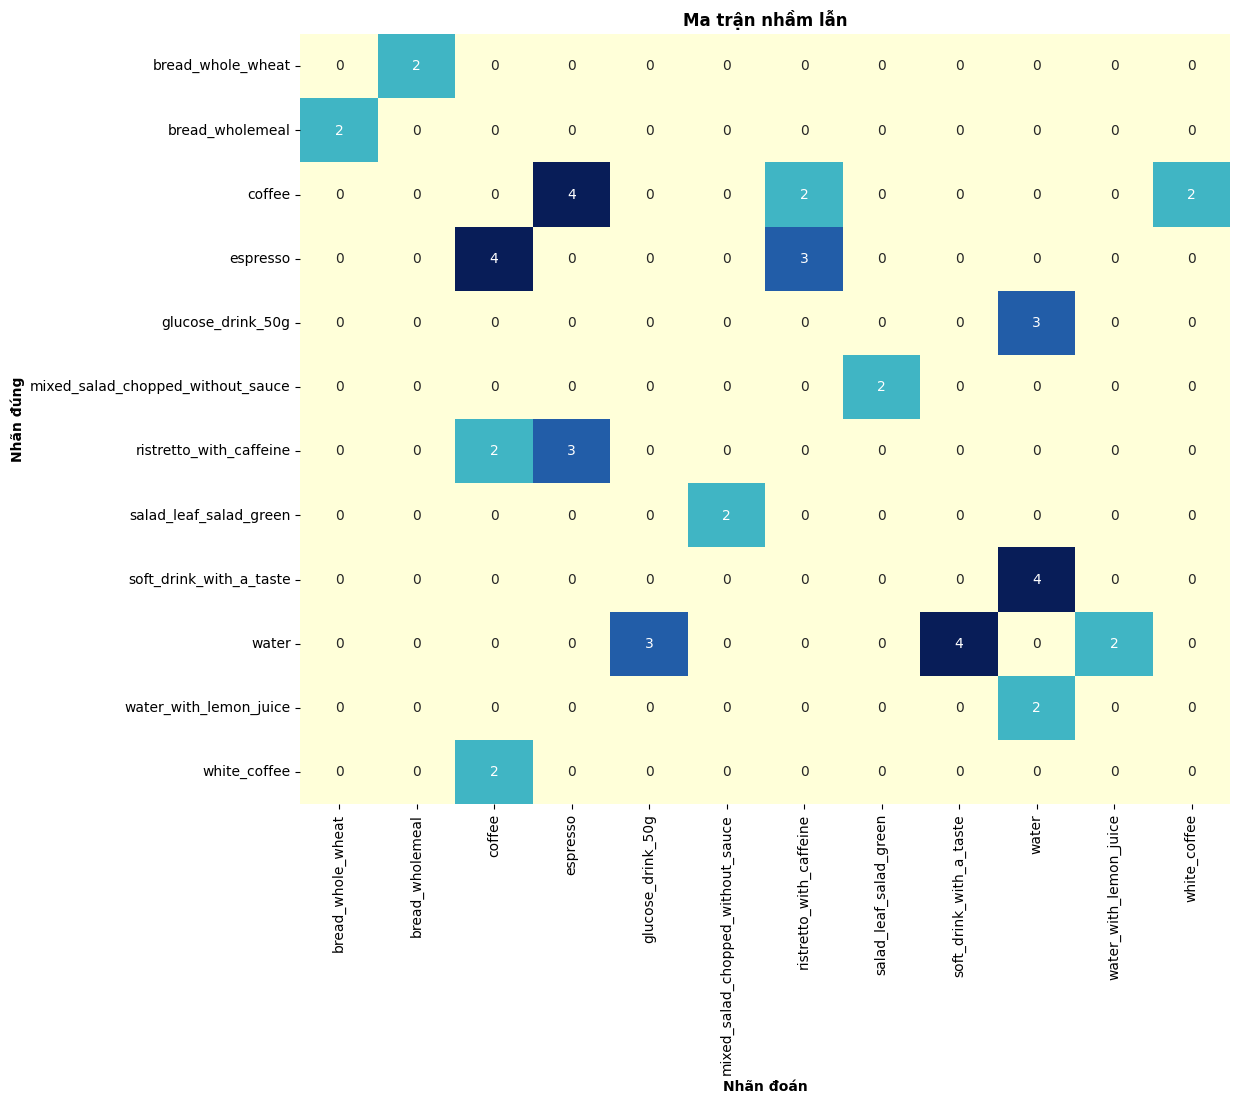

In [92]:
def confuse_matrix_true_wrong(filtered_pairs):
    # Extract unique labels
    labels = sorted(set([label for pair in filtered_pairs.keys() for label in pair]))

    # Initialize an empty matrix
    matrix = pd.DataFrame(index=labels, columns=labels)
    matrix = matrix.fillna(0)

    # Fill the matrix with counts
    for (label1, label2), count in filtered_pairs.items():
        matrix.loc[label1, label2] = count
        matrix.loc[label2, label1] = count

    # Plotting the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(matrix, annot=True, cmap='YlGnBu', fmt='g', cbar=False)
    plt.title('Ma trận nhầm lẫn', fontweight='bold')
    plt.xlabel('Nhãn đoán', fontweight='bold')
    plt.ylabel('Nhãn đúng', fontweight='bold')
    plt.savefig('heatmap-thres-max.pdf', format='pdf', bbox_inches='tight')
    plt.show()

confuse_matrix_true_wrong(filtered_pairs)

## max threshold

In [30]:
#### Run this cell when run this notebook for the first time 
#    to create the pairs of true labels and guessed labels at max threshold 
#    then repeat steps in 0.5 threshold. ####

# create_true_guess('val', 'max', 'true_guess.pt')

In [93]:
true_guess = torch.load('true_guess.pt')
len(true_guess)
# true_guess

577

In [94]:
# Separate pairs into pairs that guessed 1 label correctly and pairs that guessed completely wrong.
true_guess_1, true_guess_wr = split_1TP_wr(true_guess)
print(len(true_guess_1),';',len(true_guess_wr))
# true_guess_1
# true_guess_wr

221 ; 356


In [97]:
misclassified_labels_in_true_set, misclassified_labels_in_guess_set = count_frequently_misclassified_labels(true_guess_wr)
# misclassified_labels_in_true_set
# misclassified_labels_in_guess_set

In [98]:
wr_pairs = to_pair_true_guess(true_guess_wr)
# wr_pairs

In [99]:
data_x, s = readData(wr_pairs)
# print(s.items())
a = TP(data=data_x, s=s, minSup=6)
print(a.miningResults()[2])

[{'espresso', 'coffee'}, {'bread_whole_wheat', 'bread_wholemeal'}, {'bread_wholemeal', 'butter'}]


### Confusing matrix for pairs in completely wrong pairs (wr_pairs)

In [100]:
food_pairs = wr_pairs_count(wr_pairs)
# food_pairs

In [180]:
# remove pairs that appear too rarely
filtered_pairs = {key: value for key, value in food_pairs.items() if value > 2}
filtered_pairs

{('bread_whole_wheat', 'bread_wholemeal'): 10,
 ('bread_wholemeal', 'butter'): 7,
 ('coffee', 'espresso'): 6,
 ('egg_scrambled', 'risotto'): 4,
 ('bell_pepper_red_raw', 'mixed_vegetables'): 4,
 ('bread', 'bread_wholemeal'): 4,
 ('mixed_salad_chopped_without_sauce', 'salad_leaf_salad_green'): 4,
 ('coffee', 'white_coffee'): 4,
 ('rice', 'risotto'): 4,
 ('soft_drink_with_a_taste', 'water'): 4,
 ('braided_white_loaf_ch', 'bread_white'): 3,
 ('mixed_vegetables', 'salad_leaf_salad_green'): 3,
 ('mushroom', 'pizza_with_vegetables_baked'): 3,
 ('bread_grain', 'bread_wholemeal'): 3,
 ('gruyere_ch', 'hard_cheese'): 3,
 ('mixed_vegetables', 'rice'): 3,
 ('cheese_n_s', 'hard_cheese'): 3,
 ('avocado', 'chinese_cabbage'): 3,
 ('glucose_drink_50g', 'water'): 3,
 ('lasagne_meat_prepared', 'quiche'): 3,
 ('espresso', 'ristretto_with_caffeine'): 3,
 ('salad_lambs_ear', 'salad_leaf_salad_green'): 3}

C:\Users\dangc\AppData\Local\Temp\ipykernel_14172\587054758.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix = matrix.fillna(0)


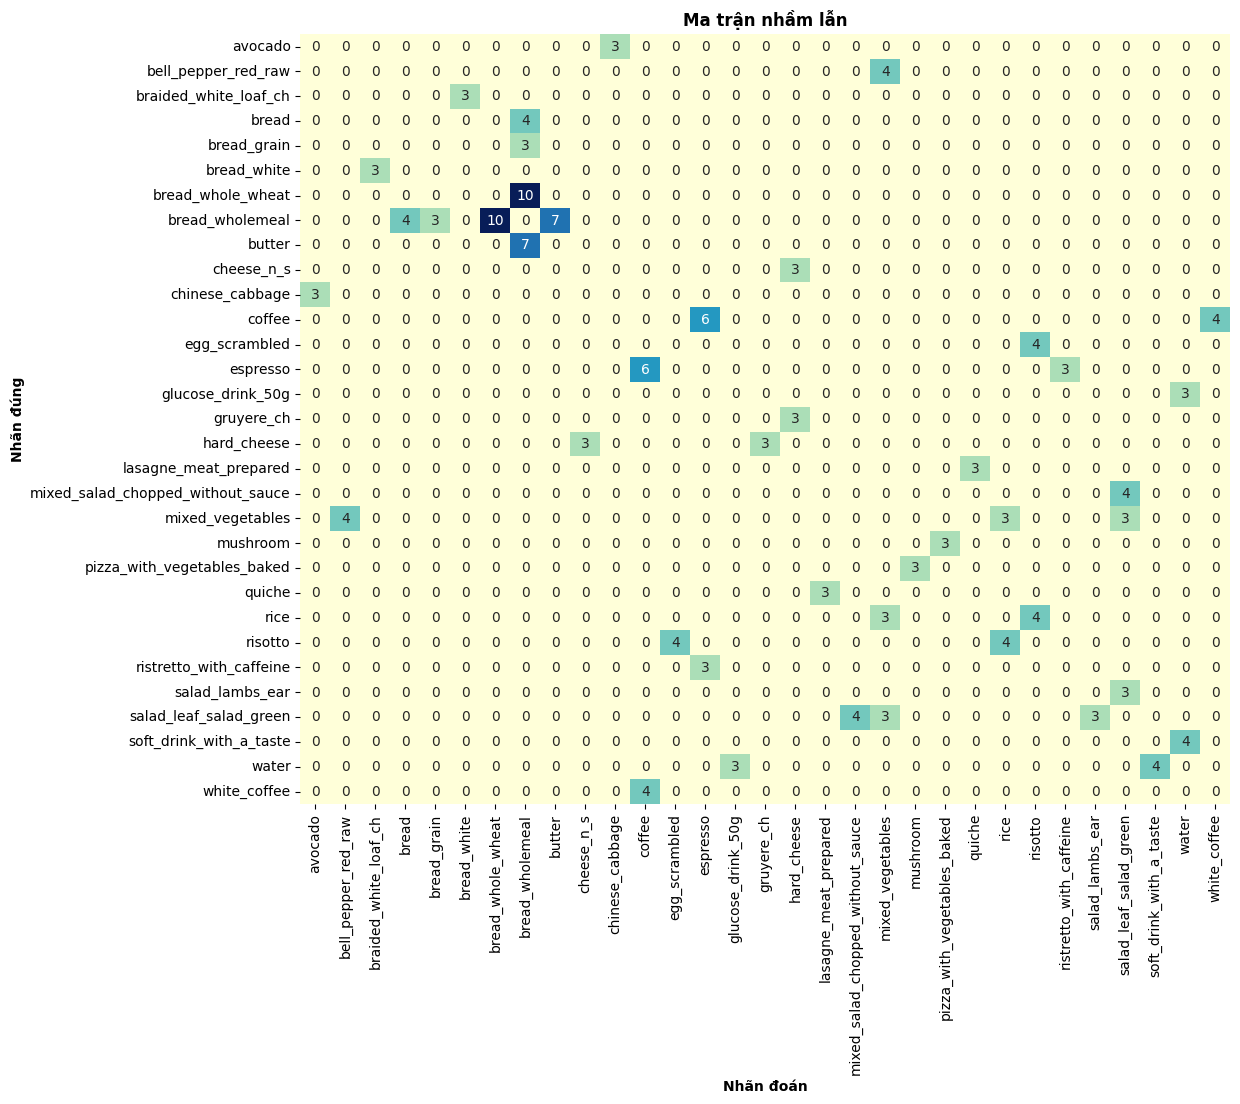

In [181]:
confuse_matrix_true_wrong(filtered_pairs)

## View confusing pictures

In [39]:
phase = 'val'
# show_img_have_cat_names(['water'], phase)
# show_img_have_cat_names(['soft_drink_with_a_taste'], phase)
# show_img_have_cat_names(['glucose_drink_50g'], phase)
# show_img_have_cat_names(['water_with_lemon_juice'], phase)

In [40]:
# show_img_have_cat_names(['coffee'], phase)
# show_img_have_cat_names(['espresso'], phase)
# show_img_have_cat_names(['white_coffee'], phase)
# show_img_have_cat_names(['ristretto_with_caffeine'], phase)

In [41]:
# show_img_have_cat_names(['butter'], phase)
# show_img_have_cat_names(['bread'], phase)
# show_img_have_cat_names(['bread_white'], phase)
# show_img_have_cat_names(['bread_grain'], phase)
# show_img_have_cat_names(['bread_wholemeal'], phase)
# show_img_have_cat_names(['bread_whole_wheat'], phase)

In [42]:
# show_img_have_cat_names(['mixed_salad_chopped_without_sauce'], phase)
# show_img_have_cat_names(['salad_leaf_salad_green'], phase)
# show_img_have_cat_names(['mixed_vegetables'], phase)
# show_img_have_cat_names(['bell_pepper_red_raw'], phase)

In [57]:
# show_img_have_cat_names(['rice'],phase)
# show_img_have_cat_names(['risotto'],phase)
# show_img_have_cat_names(['egg_scrambled'],phase)

## Frequent itemset mining at original training label set

In [105]:
# get the label set
true_labels = []
phase = 'train'
base_path = '../fdata'
true_labels = sorted([sorted([category_names[i] for i in np.where(_ == 1)[0]]) for _ in data[phase]['labels']])
# true_labels
len(true_labels)

54392

In [172]:
data_x, s = readData(true_labels)
a = TP(data=data_x, s=s, minSup=500) # The average number of images per label in the training set is 290
res = a.miningResults()

In [173]:
for key in list(res.keys())[1:-1]:
    print(key, res[key])

2 [{'bread_wholemeal', 'butter'}, {'bread_white', 'butter'}, {'salad_leaf_salad_green', 'tomato'}]


### Calculate the probability of labels appearing together
The label pairs {'butter', 'bread_wholemeal'}, {'bread_white', 'butter'} and {'salad_leaf_salad_green', 'tomato'} often appear together in the training set, which can lead to misclassification by the model. Let's analyze it further.

In [108]:
def count_A_appear_with_at_least_1_of_B(items_to_check, items_to_find):
    count = 0
    for itemset in true_labels:
        if set(items_to_check).issubset(set(itemset)) and set(items_to_find).intersection(set(itemset)):
            count += 1
            # print(itemset)
    return count

count_A_appear_with_at_least_1_of_B(['butter'], ['bread_white', 'bread_wholemeal'])

1123

In [113]:
phase = 'train'
d = count_pic_have_all_cat_names(['butter'], phase)
a = count_pic_have_all_cat_names(['butter', 'bread_white'], phase)
b = count_pic_have_all_cat_names(['butter', 'bread_wholemeal'], phase)
c = count_pic_have_all_cat_names(['butter', 'bread_white', 'bread_wholemeal'], phase)
print(a + b - c)

1123


In [116]:
def cal_prob(prefix, suffix):
    n1 = count_pic_have_all_cat_names(prefix, phase)
    n1_n2 = count_A_appear_with_at_least_1_of_B(prefix, suffix)
    print(f'{prefix}: {n1}')
    print(f'{prefix} appear with one of {suffix}: {n1_n2}')
    print(f'P({prefix}->1 of {suffix}): {n1_n2/n1 if n1 != 0 else 0}')

def cal_prob_2_direct(item1, item2):
    cal_prob(item1, item2)
    cal_prob(item2, item1)

cal_prob_2_direct(['tomato'],['salad_leaf_salad_green'])

['tomato']: 2686
['tomato'] appear with one of ['salad_leaf_salad_green']: 757
P(['tomato']->1 of ['salad_leaf_salad_green']): 0.28183172002978407
['salad_leaf_salad_green']: 2807
['salad_leaf_salad_green'] appear with one of ['tomato']: 757
P(['salad_leaf_salad_green']->1 of ['tomato']): 0.269682935518347


In [50]:
cal_prob_2_direct(['butter'],['bread_wholemeal'])

['butter']: 2180
['butter'] appear with one of ['bread_wholemeal']: 512
P(['butter']->1 of ['bread_wholemeal']): 0.23486238532110093
['bread_wholemeal']: 2030
['bread_wholemeal'] appear with one of ['butter']: 512
P(['bread_wholemeal']->1 of ['butter']): 0.2522167487684729


In [51]:
cal_prob_2_direct(['butter'],['bread_white', 'bread_wholemeal'])

['butter']: 2180
['butter'] appear with one of ['bread_white', 'bread_wholemeal']: 1123
P(['butter']->1 of ['bread_white', 'bread_wholemeal']): 0.5151376146788991
['bread_white', 'bread_wholemeal']: 21
['bread_white', 'bread_wholemeal'] appear with one of ['butter']: 5
P(['bread_white', 'bread_wholemeal']->1 of ['butter']): 0.23809523809523808


In [52]:
cal_prob_2_direct(['butter'], ['bread','bread_white','bread_grain','bread_wholemeal','bread_whole_wheat'])

['butter']: 2180
['butter'] appear with one of ['bread', 'bread_white', 'bread_grain', 'bread_wholemeal', 'bread_whole_wheat']: 1518
P(['butter']->1 of ['bread', 'bread_white', 'bread_grain', 'bread_wholemeal', 'bread_whole_wheat']): 0.6963302752293578
['bread', 'bread_white', 'bread_grain', 'bread_wholemeal', 'bread_whole_wheat']: 0
['bread', 'bread_white', 'bread_grain', 'bread_wholemeal', 'bread_whole_wheat'] appear with one of ['butter']: 0
P(['bread', 'bread_white', 'bread_grain', 'bread_wholemeal', 'bread_whole_wheat']->1 of ['butter']): 0


In [53]:
cal_prob_2_direct(['mixed_vegetables'], ['bell_pepper_red_raw'])

['mixed_vegetables']: 1255
['mixed_vegetables'] appear with one of ['bell_pepper_red_raw']: 10
P(['mixed_vegetables']->1 of ['bell_pepper_red_raw']): 0.00796812749003984
['bell_pepper_red_raw']: 806
['bell_pepper_red_raw'] appear with one of ['mixed_vegetables']: 10
P(['bell_pepper_red_raw']->1 of ['mixed_vegetables']): 0.01240694789081886


In [182]:
cal_prob_2_direct(['risotto'], ['egg_scrambled'])

['risotto']: 279
['risotto'] appear with one of ['egg_scrambled']: 0
P(['risotto']->1 of ['egg_scrambled']): 0.0
['egg_scrambled']: 216
['egg_scrambled'] appear with one of ['risotto']: 0
P(['egg_scrambled']->1 of ['risotto']): 0.0


### Tính toán lại mean, std

In [ ]:
data_dir = '../fdata/train/'

# Transformations
transform = transforms.Compose([
    transforms.Resize((448, 448)),  # Resize to a fixed size
    transforms.ToTensor()           # Convert to tensor
])

# Load the dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=64, shuffle=False)

# Function to calculate mean and std
def calculate_mean_std(data_loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in data_loader:
        batch_size = images.size(0)  # batch size (the last batch can have smaller size)
        images = images.view(batch_size, images.size(1), -1)  # reshape to (batch_size, channels, width*height)
        mean += images.mean(2).sum(0)  # compute mean per channel
        std += images.std(2).sum(0)    # compute std per channel
        total_images_count += batch_size

    mean /= total_images_count
    std /= total_images_count
    return mean, std

mean, std = calculate_mean_std(data_loader)
print('Mean:', mean)
print('Std:', std)

Mean: tensor([0.5957, 0.5094, 0.4278])
Std: tensor([0.2123, 0.2210, 0.2308])


In [ ]:
imagenet_mean = [0.5957, 0.5094, 0.4278]
imagenet_std = [0.2104, 0.2192, 0.2290]

torch.Size([3, 448, 448])